![](http://pic1.tsingdataedu.com/%E9%87%8F%E5%8C%96banner.jpg)

# 利用减小风格暴露减少多因子组合的历史回撤
#### 《AI量化交易》课程案例 by @Alan 

In [25]:
import math
import numpy as np
import pandas as pd
import cvxpy as cvx
import matplotlib.pyplot as plt

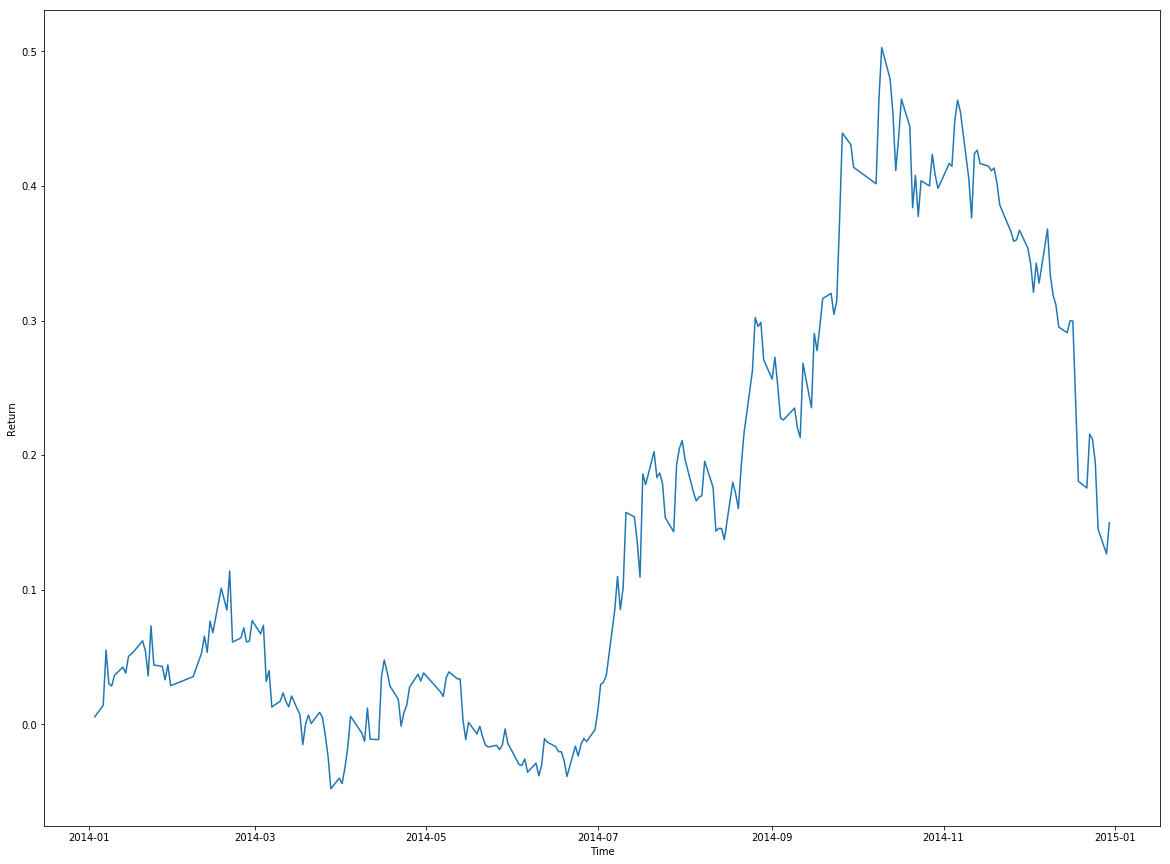

In [59]:
score=pd.read_pickle("./data/score")
zz500_close=pd.read_pickle("./data/500_close")
stock_close=pd.read_pickle("./data/stock_close")
size_factor=pd.read_pickle("./data/f9")

all_dates=list(score.index)
all_stocks=list(f1.columns)
stock_growth=stock_close.pct_change(1).shift(-1)
zz500_growth=zz500_close.pct_change(1).shift(-1)


date_returns=[]
pre_stocks=[]
for date in all_dates[:-1]:
    sort_stocks=[]
    for stock in all_stocks:
        if not math.isnan(score.loc[date,stock]) and not math.isnan(stock_growth.loc[date,stock]):
            sort_stocks.append((score.loc[date,stock],stock_growth.loc[date,stock],stock))
    sort_stocks.sort()
    return_add=0.
    for i in range(100):
        return_add+=sort_stocks[i][1]
    selected_stocks=[]
    for i in range(100):
        selected_stocks.append(sort_stocks[i][2])
    change=len(set.intersection(set(pre_stocks),set(selected_stocks)))/100
    date_returns.append(return_add/100.-zz500_growth.loc[date][0]-change*0.001)
add_date_returns=[]
for i in range(len(date_returns)):
    add_date_returns.append(sum(date_returns[0:i+1]))
plt.figure(1)
plt.figure(figsize=(20,15))
index = all_dates[:-1]
values = add_date_returns
plt.ylabel("Return")
plt.xlabel("Time")
plt.plot(index,values)
plt.show()


In [58]:
w_all=[]
for date in all_dates:
    
    w = cvx.Variable(len(all_stocks))

    objective = cvx.Maximize(-score.fillna(-100).loc[date].values*w)

    constraints = []
    single_stock_max_weight=0.01
    # weight constraints
    constraints.append(cvx.sum_entries(w)==1)

    lower_bound = []
    upper_bound = []
    for stock in all_stocks:
        bound = (0, single_stock_max_weight)
        lower_bound.append(0)
        upper_bound.append(single_stock_max_weight)
    constraints.append(w >= lower_bound)
    constraints.append(w <= upper_bound)
    size_values=size_factor.fillna(-100).loc[date].values
    constraints.append(size_values * w >= 0)

    prob = cvx.Problem(objective, constraints)

    try:
        maximum_activition = prob.solve(verbose=False, solver=cvx.ECOS, reltol=0.001)
    except:
        print(date, ' Error')
    today_w=[]
    for i in range(500):
        temp=float(w.value[i])
        if temp>0.001:
            today_w.append(temp)
        else:
            today_w.append(0)
    w_all.append(today_w)

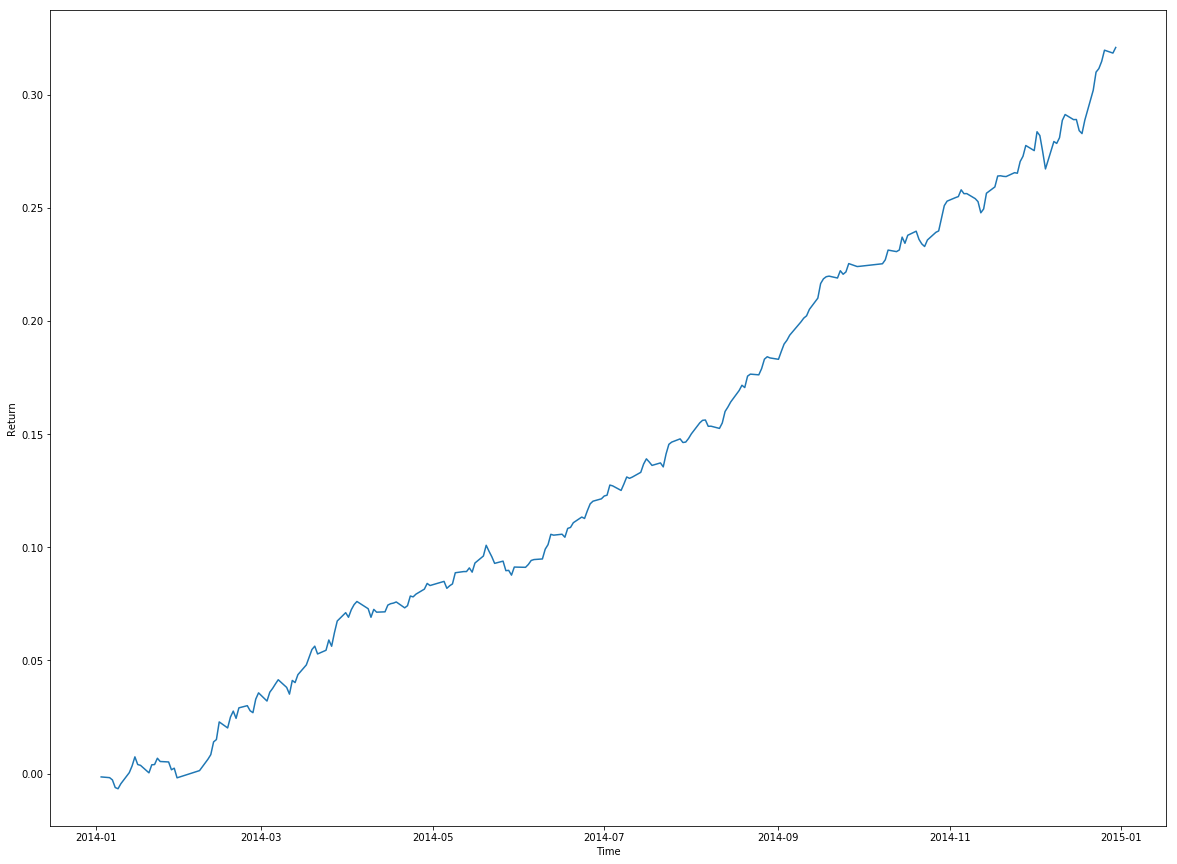

In [26]:
score=pd.read_pickle("./data/score")
zz500_close=pd.read_pickle("./data/500_close")
stock_close=pd.read_pickle("./data/stock_close")
size_factor=pd.read_pickle("./data/f9")

all_dates=list(score.index)
all_stocks=list(f1.columns)
stock_growth=stock_close.pct_change(1).shift(-1)
zz500_growth=zz500_close.pct_change(1).shift(-1)


date_returns=[]
pre_stocks=[]
date_index=0
for date in all_dates[:-1]:
    return_add=0.
    for i in range(len(all_stocks)):
        return_add+=stock_growth.loc[date,stock]*w_all[date_index][i]
       
    date_index+=1
    date_returns.append(return_add-zz500_growth.loc[date][0])
add_date_returns=[]
for i in range(len(date_returns)):
    add_date_returns.append(sum(date_returns[0:i+1]))
plt.figure(1)
plt.figure(figsize=(20,15))
index = all_dates[:-1]
values = add_date_returns
plt.ylabel("Return")
plt.xlabel("Time")
plt.plot(index,values)
plt.show()

### 版权归 © 稀牛学院 所有 保留所有权利
![](http://pic1.tsingdataedu.com/%E7%A8%80%E7%89%9B%20x%20%E7%BD%91%E6%98%93.png)